## Evaluate an LLM Powered Chatbot

Ensure all steps in [00_setup.ipynb](./00_setup.ipynb) have been completed.  

This notebook will evaluate a sample chatbo, then use that evaluation in a GitHub Actions to simulate a CI/CD pipeline. The evaluation method leverages Azure PromptFlow to orchestrate different evaluation methods and provide comprehensive scores. [Check out the Evaluation Flow](./src/evaluation/eval_flow/).

In this method [sample prompts](./src/evaluation/input_test_data.csv) are fed to the chatbot, then chatbot responses are evaluated using different approaches. Evaluation approaches in the flow include embeddings + cosine similarity, and GPT-based scores. Here is a visualization of the eval flow.  
  
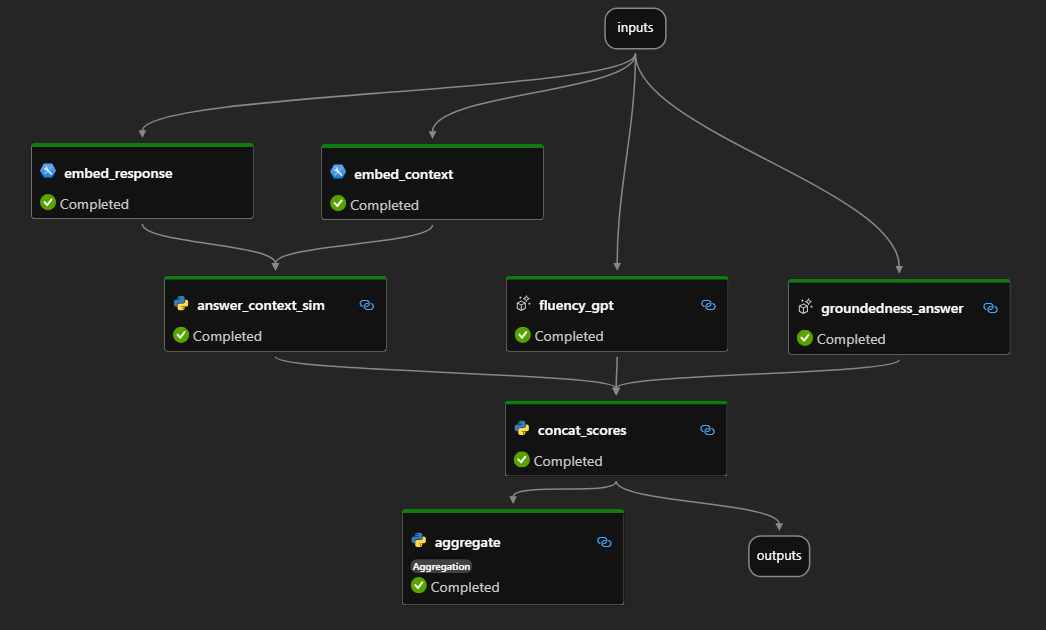

In [ ]:
# Import libraries
from promptflow.client import PFClient
import json

### Evaluate Locally with Azure Promptflow (Optional)

In [ ]:
# PFClient can help manage your runs and connections.
pf = PFClient()

# Define Flows and Data
chat_flow = "./src/promptflows/chat_rag_wiki" # set the flow directory
eval_flow = "./src/evaluation/eval_flow" # set flow directory
data = "./src/evaluation/input_test_data.csv" # set the data file

# Run chat flow to generate chat results
rag_chat_run = pf.run(
    flow=chat_flow,
    data=data,
    stream=False,
    column_mapping={  # map the url field from the data to the url input of the flow
      "input": "${data.input}",
    }
)

# Run evaluation flow to evaluate chat results
rag_eval_run = pf.run(
    flow=eval_flow,
    data=data,
    run=rag_chat_run,
    stream=False,
    column_mapping={  # map the url field from the data to the url input of the flow
      "question": "${data.input}",
      "answer": "${run.outputs.answer}",
      "context": "${run.outputs.context}"
    }
)

In [ ]:
display(pf.get_details(rag_eval_run))

display(json.dumps(pf.get_metrics(rag_eval_run)))

In [ ]:
metric_dict = dict(pf.get_metrics(rag_eval_run))
metric_dict['fluency']

### Create Script for CI/CD tests

In [ ]:
%%writefile src/evaluation/test_chat_quality.py

from promptflow.azure import PFClient
from promptflow.entities import Run
from azure.identity import DefaultAzureCredential
import os


def quality_test(): 
  
  pf = PFClient(credential=DefaultAzureCredential(),
                subscription_id=os.environ.get('SUBSCRIPTION_ID'),
                resource_group_name=os.environ.get('RESOURCE_GROUP_NAME'),
                workspace_name=os.environ.get('WORKSPACE_NAME')
                )
  
  # Define Flows and Data
  chat_flow = "./src/promptflows/chat_rag_wiki" # set the flow directory
  eval_flow = "./src/evaluation/eval_flow" # set flow directory
  data = "./src/evaluation/input_test_data.csv" # set the data file

  # Define remote compute instance (serverless)
  resources = {"instance_type": "Standard_D2"}

 ##### Run chat flow #########
  chat_run = Run(
      display_name="Chat RAG Wiki Run",
      flow=chat_flow,
      data=data,
      resources=resources,
      column_mapping={  # map the url field from the data to the url input of the flow
        "input": "${data.input}",
      }
  )

  chat_run_job = pf.runs.create_or_update(
    run=chat_run,
)
  
  pf.runs.stream(chat_run_job) # This is important - essentially a wait function

 ###############################

 ##### Run eval flow  #########
  eval_run = Run(
      display_name="Eval RAG Wiki Run",
      flow=eval_flow,
      data=data,
      run=chat_run,
      stream=False,
      resources=resources,
      column_mapping={  # map the url field from the data to the url input of the flow
        "question": "${data.input}",
        "answer": "${run.outputs.answer}",
        "context": "${run.outputs.context}"
      }
  )

  eval_run_job = pf.runs.create_or_update(
    run=eval_run,
  )
  
  pf.runs.stream(eval_run_job)

 ###############################

 # Run Tests with Assertions

  metric_dict = dict(pf.get_metrics(eval_run_job))

  print(f"RESULTS: {metric_dict}")

  assert(metric_dict['fluency'] >= 4)
  assert(metric_dict['answer_context_sim'] >= 0.85)
  assert(metric_dict['groundedness'] >= 4)

  return

if __name__ == "__main__":
  quality_test()  

### Create Github Action YAML file

In [ ]:
%%writefile ./.github/workflows/llm_eval.yml

name: llm_eval
# Controls when the workflow will run
on:
  pull_request:
    branches: [ "main" ]

  # Allows you to run this workflow manually from the Actions tab
  workflow_dispatch:

jobs:
  build:
    runs-on: ubuntu-latest

    steps:
      - name: Checkout Repo 
        uses: actions/checkout@v3

      - name: Setup Python
        uses: actions/setup-python@v3
        with:
          python-version: 3.8

      - name: Install Dependencies
        run: |
          python -m pip install --upgrade pip
          pip install promptflow promptflow-azure promptflow-tools keyrings.alt bs4 azure-identity

      - name: Install az ml extension
        run: az extension add -n ml -y

      - name: Azure login
        uses: azure/login@v1
        with:
          creds: '${{ secrets.AZURE_CREDENTIALS }}'
      
      - name: Test Chat Quality
        env:
          RESOURCE_GROUP_NAME: ${{ secrets.RESOURCE_GROUP_NAME }}
          WORKSPACE_NAME: ${{ secrets.WORKSPACE_NAME }}
          SUBSCRIPTION_ID: ${{ secrets.SUBSCRIPTION_ID }}
        run: |
          az configure --defaults group='${{ env.RESOURCE_GROUP_NAME }}'
          az configure --defaults workspace='${{ env.WORKSPACE_NAME }}'
          python ./src/evaluation/test_chat_quality.py


### Trigger GitHub Action

1. Take a look [Github Workflow](./.github/workflows/llm_eval.yml) yaml definition to understand execution steps
2. Push the repository to GitHub
3. Run the flow through the GitHub UI. Go to Actions --> llm_eval --> Run Workflow

### Continued Reading: Other Evaluation Methods to Consider Implementing
1. [RAGAS](https://ragas.io/) - open source standard for evaluating LLM application
2. [Chain Poll](https://arxiv.org/abs/2310.18344) - A high efficacy method for LLM hallucination detection
3. Fine-Tuned LMs
   - [NLI Deberta](https://huggingface.co/cross-encoder/nli-deberta-v3-base) - Contradicition detection based on Microsoft's Deberta-v3-base model
   - [HHEM](https://huggingface.co/vectara/hallucination_evaluation_model) - Hughes Hallucination Evaluation Model